In [ ]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
from scipy.stats import spearmanr, pearsonr, ranksums, linregress
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib
import itertools
import statannot
from statsmodels.stats.multitest import fdrcorrection
from scipy import stats

import pickle

from deeplift.visualization import viz_sequence


matplotlib.rcParams['figure.dpi'] = 120
matplotlib.rcParams['font.sans-serif'] = 'Helvetica'


HEPG2_COL = 'log2FoldChange_HepG2'
K562_COL = 'log2FoldChange_K562'
H2K_COL = 'log2FoldChange_H2K'

figure_dir = 'figures'
supp_figure_dir = f'{figure_dir}/supp_figures'

TITLE_FSIZE = 12
AXIS_FSIZE = 12
TEXT_FSIZE = 10

greysBig = matplotlib.cm.get_cmap('Greys', 512)
greys_trunc_cm = matplotlib.colors.ListedColormap(greysBig(np.linspace(0.6, 1, 256)))

bluesBig = matplotlib.cm.get_cmap('Blues', 512)
# blues_trunc_cm = matplotlib.colors.ListedColormap(bluesBig(np.linspace(0.15, 0.8, 256)))
blues_trunc_cm = matplotlib.colors.ListedColormap(bluesBig(np.linspace(0.25, 0.8, 256)))

orangesBig = matplotlib.cm.get_cmap('Oranges', 512)
# oranges_trunc_cm = matplotlib.colors.ListedColormap(orangesBig(np.linspace(0.15, 0.8, 256)))
oranges_trunc_cm = matplotlib.colors.ListedColormap(orangesBig(np.linspace(0.25, 0.8, 256)))

from fig_utils import plot_scatter_shaded, load_ensemble_model, load_model_for_shap, plot_seq_with_motifs, cluster_name_dict, seq_to_one_hot,round_palette

# import logging from matplotlib
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

from matplotlib import rcParams
rcParams['svg.fonttype'] = 'none'

D2_HEPG2_COL = 'log2FoldChange_HEPG2'
D2_K562_COL = 'log2FoldChange_K562'

HEPG2_SE_COL = 'lfcSE_HEPG2'
K562_SE_COL = 'lfcSE_K562'
H2K_SE_COL = 'lfcSE_H2K'

D3_HEPG2_SE_COL = 'lfcSE_HepG2_DNA'
D3_K562_SE_COL = 'lfcSE_K562_DNA'

D1_HEPG2_SE_COL = 'lfcSE_HEPG2_DNA'
D1_K562_SE_COL = 'lfcSE_K562_DNA'

fig1_dir = f'{figure_dir}/fig1'
os.makedirs(fig1_dir,exist_ok=True)

custom_color_vec = ["#FC440F","#5B5F97","#FFC145","#BBE1C3","#6C9A8B"]
custom_green_palette = sns.cubehelix_palette(start=2, rot=0, dark=0, light=.95)

round_palette = {
    'R0': sns.color_palette("Grays", 5)[2],
    'R1': custom_color_vec[3],
    'R2': custom_green_palette[3],
}

In [2]:
### Load D1, D2, and D3 data ###

# reverse complement function
def reverse_complement(seq):
    complement = {'A': 'T', 'C': 'G', 'G': 'C', 'T': 'A'}
    return ''.join(complement[base] for base in reversed(seq))

bc_deseqs_dir = 'bc_deseq_dfs/weighted/comb_dhs'

d2_deseq_df = pd.read_csv(f'{bc_deseqs_dir}/d2_deseq_df.csv')
d3_seq_df = pd.read_csv(f'{bc_deseqs_dir}/d3_seq_df.csv')
dhs_deseq_df = pd.read_csv(f'{bc_deseqs_dir}/dhs_deseq_df.csv')

d1_deseq_plus_cluster_cnts_df = pd.read_csv(f'{bc_deseqs_dir}/d1_deseq_plus_cluster_cnts_df.csv')
d2_deseq_plus_cluster_cnts_df = pd.read_csv(f'{bc_deseqs_dir}/d2_deseq_plus_cluster_cnts_df.csv')
d3_deseq_plus_cluster_cnts_df = pd.read_csv(f'{bc_deseqs_dir}/d3_deseq_plus_cluster_cnts_df.csv')

# d1_deseq_plus_cluster_cnts_df['sequence_name'] = d1_deseq_plus_cluster_cnts_df.index
# d1_deseq_plus_cluster_cnts_df['sequence_name'] = d1_deseq_plus_cluster_cnts_df['sequence_name'].apply(lambda x: f'd1_seq_{x}')

# for any seqs in d2_deseq_df with enhancer column matching a seq column in d1_deseq_plus_cluster_cnts_df, reassign sequence_name column in d2_deseq_df to corresponding column in d1_deseq_plus_cluster_cnts_df
for idx,row in d2_deseq_df.iterrows():
    cur_enhancer = row['enhancer']
    if cur_enhancer in d1_deseq_plus_cluster_cnts_df['seq'].values:
        d1_seq_name = d1_deseq_plus_cluster_cnts_df.loc[d1_deseq_plus_cluster_cnts_df['seq']==cur_enhancer,'sequence_name'].values[0]
        d2_deseq_df.loc[idx,'sequence_name'] = d1_seq_name
        # also rename the row in d2_deseq_df where enhancer is the reverse_complement of this enhancer
        d2_deseq_df.loc[d2_deseq_df['enhancer']==reverse_complement(cur_enhancer),'sequence_name'] = f'{d1_seq_name}_rc'

d2_deseq_plus_cluster_cnts_df['sequence_name'] = d2_deseq_df['sequence_name']
# rename log2FoldChange_HEPG2 to HEPG2_COL in d2_deseq_plus_cluster_cnts_df
d2_deseq_plus_cluster_cnts_df.rename(columns={'log2FoldChange_HEPG2': HEPG2_COL}, inplace=True)

# for any seqs in d3_deseq_df with enhancer column matching a seq column in d1_deseq_plus_cluster_cnts_df, reassign sequence_name column in d3_deseq_df to corresponding column in d1_deseq_plus_cluster_cnts_df
for idx,row in d3_seq_df.iterrows():
    cur_enhancer = row['sequence']
    if cur_enhancer in d1_deseq_plus_cluster_cnts_df['seq'].values:
        d1_seq_name = d1_deseq_plus_cluster_cnts_df.loc[d1_deseq_plus_cluster_cnts_df['seq']==cur_enhancer,'sequence_name'].values[0]
        d3_seq_df.loc[idx,'sequence_name'] = d1_seq_name
    elif reverse_complement(cur_enhancer) in d1_deseq_plus_cluster_cnts_df['seq'].values:
        d1_seq_name = d1_deseq_plus_cluster_cnts_df.loc[d1_deseq_plus_cluster_cnts_df['seq']==reverse_complement(cur_enhancer),'sequence_name'].values[0]
        d3_seq_df.loc[d3_seq_df['sequence']==reverse_complement(cur_enhancer),'sequence_name'] = f'{d1_seq_name}_rc'

d3_deseq_plus_cluster_cnts_df['sequence_name'] = d3_seq_df['sequence_name']


# d2_deseq_df = pd.read_csv('../../../aws/for_aws/sequencing_analysis/d2_deseq_data/chris_log2fc_df_clean2.csv')

d1_final_df = pd.read_csv('../../../aws/for_aws/sequencing_analysis/fimo_motif_scanning/saved_processed_motif_files/d1_final_df_qthresh05_v2.csv')
d2_final_df = pd.read_csv('../../../aws/for_aws/sequencing_analysis/fimo_motif_scanning/saved_processed_motif_files/d2_final_df_qthresh05_v2.csv')
d3_final_df = pd.read_csv('../designed_seqs/d3_tot_final_df_qthresh0.05.csv')

# get the max log2FoldChange_H2K_deseq for rows of analysis_df where model_type is control
h2k_ctrl_max = d3_seq_df.loc[d3_seq_df['model_type']=="d2_meas",H2K_COL].max()
# get the min log2FoldChange_H2K_deseq for rows of analysis_df where model_type is control
h2k_ctrl_min = d3_seq_df.loc[d3_seq_df['model_type']=="d2_meas",H2K_COL].min()

### Fig 1B-E: Scatterplot evolution ###

C:\Users\Chris\AppData\Local\Temp\ipykernel_4876\214510622.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  greysBig = matplotlib.cm.get_cmap('Greys', 512)
C:\Users\Chris\AppData\Local\Temp\ipykernel_4876\214510622.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  bluesBig = matplotlib.cm.get_cmap('Blues', 512)
C:\Users\Chris\AppData\Local\Temp\ipykernel_4876\214510622.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  orangesBig = matplotlib.cm.get_cmap('Oranges', 51

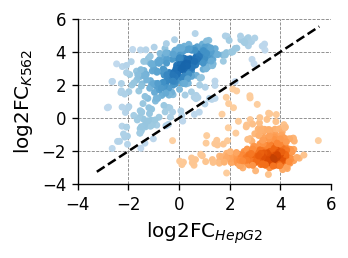

In [28]:
# First analysis: look at all sequences designed to maximize H2K/K2H unbounded or clipped (so, exclude target...but maybe include max1/min1?)
model_types = ['d1_finetuned', 'd2_dhs'] # shuffled and D2 are the NCs

design_types = ['fsp','fsp_clipped']
analysis_df = d3_seq_df[(d3_seq_df['model_type'].isin(model_types)) & (d3_seq_df['design_type'].isin(design_types))].copy()
# rename 'log2FoldChange_HepG2_DNA' to HEPG2_COL, 'log2FoldChange_K562_DNA' to K562_COL
analysis_df.rename(columns={'log2FoldChange_HepG2_DNA': HEPG2_COL, 'log2FoldChange_K562_DNA': K562_COL}, inplace=True)
# drop log2(SKNSH_pred) column
analysis_df.drop(columns=['log2(SKNSH)_pred'], inplace=True)
analysis_df.shape

TARGET_COL = 'cell_type_plus_ctrl'
# initialize
analysis_df[TARGET_COL] = analysis_df['cell_type']

greysBig = matplotlib.cm.get_cmap('Greys', 512)
greys_trunc_cm = matplotlib.colors.ListedColormap(greysBig(np.linspace(0.4, 1, 256)))

bluesBig = matplotlib.cm.get_cmap('Blues', 512)
# blues_trunc_cm = matplotlib.colors.ListedColormap(bluesBig(np.linspace(0.15, 0.8, 256)))
blues_trunc_cm = matplotlib.colors.ListedColormap(bluesBig(np.linspace(0.25, 0.8, 256)))

orangesBig = matplotlib.cm.get_cmap('Oranges', 512)
# oranges_trunc_cm = matplotlib.colors.ListedColormap(orangesBig(np.linspace(0.15, 0.8, 256)))
oranges_trunc_cm = matplotlib.colors.ListedColormap(orangesBig(np.linspace(0.25, 0.8, 256)))

# create ax
fig,ax = plt.subplots(figsize=(3,2.25))
alpha = 1
s = 10


plot_scatter_shaded(analysis_df[analysis_df['cell_type']=='HEPG2'][HEPG2_COL], analysis_df[analysis_df['cell_type']=='HEPG2'][K562_COL],
                    ax, xlim=(-4.5, 6), ylim=(-4.5, 6), linreg=False, cmap=oranges_trunc_cm,alpha=alpha,s=s)

plot_scatter_shaded(analysis_df[analysis_df['cell_type']=='K562'][HEPG2_COL], analysis_df[analysis_df['cell_type']=='K562'][K562_COL],
                    ax, xlim=(-4.5, 6), ylim=(-4.5, 6), linreg=False, cmap=blues_trunc_cm,alpha=alpha,s=s)

# add line of slope 1
xmin,xmax = ax.get_xlim()
ymin,ymax = ax.get_ylim()
xmin = max(xmin,ymin)
xmax = min(xmax,ymax)
ax.plot([xmin,xmax],[xmin,xmax],linestyle='--',color='black',zorder=21)

# despine
sns.despine()

# xlabel
ax.set_xlabel('log2FC$_{HepG2}$',fontsize=AXIS_FSIZE)
# ylabel
ax.set_ylabel('log2FC$_{K562}$',fontsize=AXIS_FSIZE)

# xticks
ax.set_xticks(np.arange(-4,6.1,2))
# yticks
ax.set_yticks(np.arange(-4,6.1,2))

# gridlines
ax.grid(color='gray',linestyle='--',linewidth=0.5,zorder=-20)


fig1_dir = f'{figure_dir}/fig1'
os.makedirs(fig1_dir,exist_ok=True)

# save figure
plt.tight_layout()
plt.savefig(f'{fig1_dir}/r2_scatterplot.png',dpi=600,bbox_inches='tight',transparent=True)

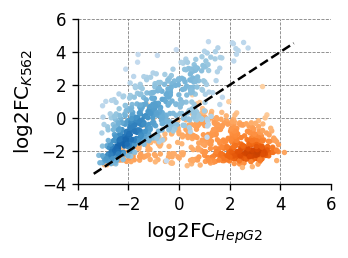

In [23]:
## d2/r1 scatterplot ##

# plot the d2 scatterplot

analysis_df = d2_deseq_plus_cluster_cnts_df.loc[~d2_deseq_plus_cluster_cnts_df['design_type'].isin(['control','motif_repeat'])].copy()
analysis_df = analysis_df[analysis_df['model_type']!='df'].copy()
# ctrl_df = d2_deseq_plus_cluster_cnts_df.loc[d2_deseq_plus_cluster_cnts_df['generator']=='control'].copy()

hepg2_plot_col = f'{HEPG2_COL}' #log2FoldChange_HEPG2'
k562_plot_col = f'{K562_COL}'# 'log2FoldChange_K562'

# create ax
fig,ax = plt.subplots(figsize=(3,2.25))

plot_scatter_shaded(analysis_df[analysis_df['cell_type']=='HEPG2'][hepg2_plot_col], analysis_df[analysis_df['cell_type']=='HEPG2'][k562_plot_col],
                    ax, linreg=False, cmap=oranges_trunc_cm,s=5) #xlim=(-4.5, 6), ylim=(-4.5, 6)

plot_scatter_shaded(analysis_df[analysis_df['cell_type']=='K562'][hepg2_plot_col], analysis_df[analysis_df['cell_type']=='K562'][k562_plot_col],
                    ax, linreg=False, cmap=blues_trunc_cm,s=5) #xlim=(-4.5, 6), ylim=(-4.5, 6)


# add slope 1 line
xmin,xmax = ax.get_xlim()
ymin,ymax = ax.get_ylim()
xmin = max(xmin,ymin)
xmax = min(xmax,ymax)
ax.plot([xmin,xmax],[xmin,xmax],linestyle='--',color='black',zorder=25)

# despine
sns.despine()

# xlabel
ax.set_xlabel('log2FC$_{HepG2}$',fontsize=AXIS_FSIZE)
# ylabel
ax.set_ylabel('log2FC$_{K562}$',fontsize=AXIS_FSIZE)

# xticks
ax.set_xticks(np.arange(-4,6.1,2))
# yticks
ax.set_yticks(np.arange(-4,6.1,2))

# gridlines
ax.grid(color='gray',linestyle='--',linewidth=0.5,zorder=-20)



# Display the plot
# save plot
plt.tight_layout()
plt.savefig(f'{fig1_dir}/r1_scatterplot.png',dpi=600,bbox_inches='tight',transparent=True)


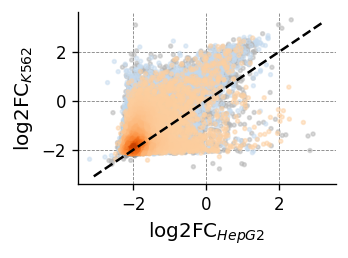

In [29]:
## d1/r0 scatterplot ##

analysis_df = d1_deseq_plus_cluster_cnts_df.copy()

# create ax
fig,ax = plt.subplots(figsize=(3,2.25))

alpha=0.5
s=5
plot_scatter_shaded(analysis_df[analysis_df['cell_type']=='NC'][f'{HEPG2_COL}'],
                    analysis_df[analysis_df['cell_type']=='NC'][f'{K562_COL}'],
                    ax, xlim=(-4.5, 6), ylim=(-4.5, 6), linreg=False, cmap=greys_trunc_cm,alpha=alpha,s=s)

plot_scatter_shaded(analysis_df[analysis_df['cell_type']=='K562'][f'{HEPG2_COL}'],
                    analysis_df[analysis_df['cell_type']=='K562'][f'{K562_COL}'],
                    ax, xlim=(-4.5, 6), ylim=(-4.5, 6), linreg=False, cmap=blues_trunc_cm,alpha=alpha,s=s)


plot_scatter_shaded(analysis_df[analysis_df['cell_type']=='HEPG2'][f'{HEPG2_COL}'],
                    analysis_df[analysis_df['cell_type']=='HEPG2'][f'{K562_COL}'],
                    ax, xlim=(-4.5, 6), ylim=(-4.5, 6), linreg=False, cmap=oranges_trunc_cm,alpha=alpha,s=s)


# plot_scatter_shaded(analysis_df['log2FoldChange_HEPG2_DNA'],
#                     analysis_df['log2FoldChange_K562_DNA'],
#                     ax, xlim=(-4.5, 6), ylim=(-4.5, 6), linreg=False, cmap=greys_trunc_cm)

# add line of slope 1
xmin,xmax = ax.get_xlim()
ymin,ymax = ax.get_ylim()
xmin = max(xmin,ymin)
xmax = min(xmax,ymax)
ax.plot([xmin,xmax],[xmin,xmax],linestyle='--',color='black',zorder=21)

# despine
sns.despine()

# xlabel
ax.set_xlabel('log2FC$_{HepG2}$',fontsize=AXIS_FSIZE)
# ylabel
ax.set_ylabel('log2FC$_{K562}$',fontsize=AXIS_FSIZE)

# # xticks
# ax.set_xticks(np.arange(-4,6.1,2))
# # yticks
# ax.set_yticks(np.arange(-4,6.1,2))

# gridlines
ax.grid(color='gray',linestyle='--',linewidth=0.5,zorder=-20)


# save figure
plt.tight_layout()
plt.savefig(f'{fig1_dir}/r0_scatterplot.png',dpi=600,bbox_inches='tight',transparent=True)

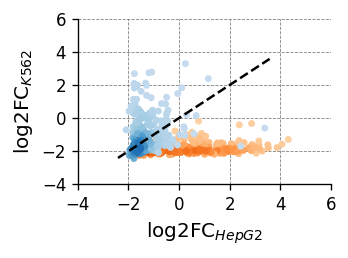

In [27]:
analysis_df = dhs_deseq_df[dhs_deseq_df['design_type']=='gan'].copy()

# create ax
fig,ax = plt.subplots(figsize=(3,2.25))
alpha = 1
s = 10


plot_scatter_shaded(analysis_df[analysis_df['cell_type']=='HEPG2'][HEPG2_COL], analysis_df[analysis_df['cell_type']=='HEPG2'][K562_COL],
                    ax, xlim=(-4.5, 6), ylim=(-4.5, 6), linreg=False, cmap=oranges_trunc_cm,alpha=alpha,s=s)

plot_scatter_shaded(analysis_df[analysis_df['cell_type']=='K562'][HEPG2_COL], analysis_df[analysis_df['cell_type']=='K562'][K562_COL],
                    ax, xlim=(-4.5, 6), ylim=(-4.5, 6), linreg=False, cmap=blues_trunc_cm,alpha=alpha,s=s)

# add line of slope 1
xmin,xmax = ax.get_xlim()
ymin,ymax = ax.get_ylim()
xmin = max(xmin,ymin)
xmax = min(xmax,ymax)
ax.plot([xmin,xmax],[xmin,xmax],linestyle='--',color='black',zorder=21)

# despine
sns.despine()

# xlabel
ax.set_xlabel('log2FC$_{HepG2}$',fontsize=AXIS_FSIZE)
# ylabel
ax.set_ylabel('log2FC$_{K562}$',fontsize=AXIS_FSIZE)

# xticks
ax.set_xticks(np.arange(-4,6.1,2))
# yticks
ax.set_yticks(np.arange(-4,6.1,2))

# gridlines
ax.grid(color='gray',linestyle='--',linewidth=0.5,zorder=-20)


fig1_dir = f'{figure_dir}/fig1'
os.makedirs(fig1_dir,exist_ok=True)

# save figure
plt.tight_layout()
plt.savefig(f'{fig1_dir}/r1d_scatterplot.png',dpi=600,bbox_inches='tight',transparent=True)

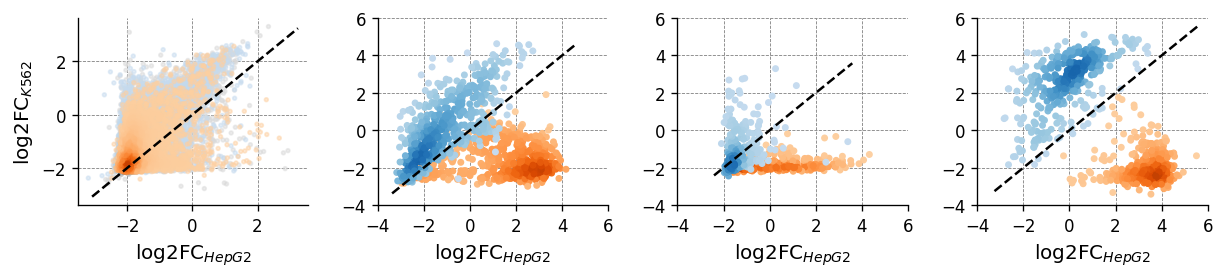

In [34]:

# create ax
# fig,ax = plt.subplots(figsize=(3,2.25))
# create a 1x4 grid of axes
fig,ax = plt.subplots(1,4,figsize=(13.5*.9,2.25*.9))

# ax0 - R0
analysis_df = d1_deseq_plus_cluster_cnts_df.copy()
alpha=0.5
s=5
plot_scatter_shaded(analysis_df[analysis_df['cell_type']=='NC'][f'{HEPG2_COL}'],
                    analysis_df[analysis_df['cell_type']=='NC'][f'{K562_COL}'],
                    ax[0], xlim=(-4.5, 6), ylim=(-4.5, 6), linreg=False, cmap=greys_trunc_cm,alpha=alpha,s=s)

plot_scatter_shaded(analysis_df[analysis_df['cell_type']=='K562'][f'{HEPG2_COL}'],
                    analysis_df[analysis_df['cell_type']=='K562'][f'{K562_COL}'],
                    ax[0], xlim=(-4.5, 6), ylim=(-4.5, 6), linreg=False, cmap=blues_trunc_cm,alpha=alpha,s=s)


plot_scatter_shaded(analysis_df[analysis_df['cell_type']=='HEPG2'][f'{HEPG2_COL}'],
                    analysis_df[analysis_df['cell_type']=='HEPG2'][f'{K562_COL}'],
                    ax[0], xlim=(-4.5, 6), ylim=(-4.5, 6), linreg=False, cmap=oranges_trunc_cm,alpha=alpha,s=s)

# ax1 - R1
alpha = 1
s = 10
analysis_df = d2_deseq_plus_cluster_cnts_df.loc[~d2_deseq_plus_cluster_cnts_df['design_type'].isin(['control','motif_repeat'])].copy()
analysis_df = analysis_df[analysis_df['model_type']!='df'].copy()
plot_scatter_shaded(analysis_df[analysis_df['cell_type']=='HEPG2'][HEPG2_COL], analysis_df[analysis_df['cell_type']=='HEPG2'][K562_COL],
                    ax[1], xlim=(-4.5, 6), ylim=(-4.5, 6), linreg=False, cmap=oranges_trunc_cm,alpha=alpha,s=s)

plot_scatter_shaded(analysis_df[analysis_df['cell_type']=='K562'][HEPG2_COL], analysis_df[analysis_df['cell_type']=='K562'][K562_COL],
                    ax[1], xlim=(-4.5, 6), ylim=(-4.5, 6), linreg=False, cmap=blues_trunc_cm,alpha=alpha,s=s)

# ax2 - R1 DHS
alpha = 1
s = 10
analysis_df = dhs_deseq_df[dhs_deseq_df['design_type']=='gan'].copy()
plot_scatter_shaded(analysis_df[analysis_df['cell_type']=='HEPG2'][HEPG2_COL], analysis_df[analysis_df['cell_type']=='HEPG2'][K562_COL],
                    ax[2], xlim=(-4.5, 6), ylim=(-4.5, 6), linreg=False, cmap=oranges_trunc_cm,alpha=alpha,s=s)

plot_scatter_shaded(analysis_df[analysis_df['cell_type']=='K562'][HEPG2_COL], analysis_df[analysis_df['cell_type']=='K562'][K562_COL],
                    ax[2], xlim=(-4.5, 6), ylim=(-4.5, 6), linreg=False, cmap=blues_trunc_cm,alpha=alpha,s=s)

# ax3 - R2
alpha = 1
s = 10
model_types = ['d1_finetuned', 'd2_dhs'] # shuffled and D2 are the NCs
design_types = ['fsp','fsp_clipped']
analysis_df = d3_seq_df[(d3_seq_df['model_type'].isin(model_types)) & (d3_seq_df['design_type'].isin(design_types))].copy()
plot_scatter_shaded(analysis_df[analysis_df['cell_type']=='HEPG2'][HEPG2_COL], analysis_df[analysis_df['cell_type']=='HEPG2'][K562_COL],
                    ax[3], xlim=(-4.5, 6), ylim=(-4.5, 6), linreg=False, cmap=oranges_trunc_cm,alpha=alpha,s=s)

plot_scatter_shaded(analysis_df[analysis_df['cell_type']=='K562'][HEPG2_COL], analysis_df[analysis_df['cell_type']=='K562'][K562_COL],
                    ax[3], xlim=(-4.5, 6), ylim=(-4.5, 6), linreg=False, cmap=blues_trunc_cm,alpha=alpha,s=s)


for i in range(4):
    # add line of slope 1 to all axes
    xmin,xmax = ax[i].get_xlim()
    ymin,ymax = ax[i].get_ylim()
    xmin = max(xmin,ymin)
    xmax = min(xmax,ymax)
    ax[i].plot([xmin,xmax],[xmin,xmax],linestyle='--',color='black',zorder=21)

    # xlabel
    ax[i].set_xlabel('log2FC$_{HepG2}$',fontsize=AXIS_FSIZE)
    if i > 0:
        # remove ylabel
        ax[i].set_ylabel('')
        # xticks
        ax[i].set_xticks(np.arange(-4,6.1,2))
        # yticks
        ax[i].set_yticks(np.arange(-4,6.1,2))
    else:
        # ylabel
        ax[i].set_ylabel('log2FC$_{K562}$',fontsize=AXIS_FSIZE)


    # gridlines
    ax[i].grid(color='gray',linestyle='--',linewidth=0.5,zorder=-20)

# increase space between subplots
plt.subplots_adjust(wspace=0.3)


# despine
sns.despine()



# fig1_dir = f'{figure_dir}/fig1'
# os.makedirs(fig1_dir,exist_ok=True)

# # save figure
# plt.tight_layout()
plt.savefig(f'{fig1_dir}/r1b_scatterplots.png',dpi=600,bbox_inches='tight')

### Fig 1F: Best enhancer comparison and simulated low-n library comparisons ###

In [9]:
d1_deseq_plus_cluster_cnts_df['model_type'] = 'sharpr-mpra'
d1_deseq_plus_cluster_cnts_df['design_type'] = 'sharpr-mpra'

dhs_deseq_df['model_type'] = 'dhs'
dhs_deseq_df.rename(columns={'lfcSE_HepG2':HEPG2_SE_COL},inplace=True)

Best HEPG2 enhancer R0: d1_seq_2814, 4.87
Best K562 enhancer R0: d1_seq_22263, -5.03
Best HEPG2 enhancer R1: d2_seq_433, 6.44
Best K562 enhancer R1: d2_seq_1099, -5.47
Best HEPG2 enhancer R2: designed_d1_finetuned_fsp_target_0_HEPG2_seq_136, 7.34
Best K562 enhancer R2: designed_d2_dhs_fsp_target_1_K562_seq_70, -5.99
Best HEPG2 enhancer R1 DHS: 42_HepG2_8840_634, 5.66
Best K562 enhancer R1 DHS: 42_K562_2400_275, -4.45


C:\Users\Chris\AppData\Local\Temp\ipykernel_4876\1419445617.py:66: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  top_enhancer_df = pd.concat([top_enhancer_df,cur_row[d2_analysis_cols]])


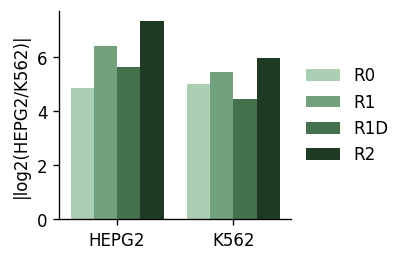

In [11]:
d1_top_hepg2 = d1_deseq_plus_cluster_cnts_df.loc[d1_deseq_plus_cluster_cnts_df[H2K_COL].idxmax(),'sequence_name']
d1_top_k562  = d1_deseq_plus_cluster_cnts_df.loc[d1_deseq_plus_cluster_cnts_df[H2K_COL].idxmin(),'sequence_name']
print(f'Best HEPG2 enhancer R0: {d1_top_hepg2}, {d1_deseq_plus_cluster_cnts_df.loc[d1_deseq_plus_cluster_cnts_df[H2K_COL].idxmax(),H2K_COL]:.2f}')
print(f'Best K562 enhancer R0: {d1_top_k562}, {d1_deseq_plus_cluster_cnts_df.loc[d1_deseq_plus_cluster_cnts_df[H2K_COL].idxmin(),H2K_COL]:.2f}')

# print(f'Best HEPG2 enhancer R0: {d1_top_hepg2}, {d2_ctrl_df.loc[d2_ctrl_df[H2K_COL].idxmax(),H2K_COL]:.2f}')
# print(f'Best K562 enhancer R0: {d1_top_k562}, {d2_ctrl_df.loc[d2_ctrl_df[H2K_COL].idxmin(),H2K_COL]:.2f}')

d2_design_df = d2_deseq_plus_cluster_cnts_df[d2_deseq_plus_cluster_cnts_df['design_type'].isin(['DENs','sim_anneal','seqprop'])].copy()
d2_top_hepg2 = d2_design_df.loc[d2_design_df[f'{H2K_COL}'].idxmax(),'sequence_name']
d2_top_k562 = d2_design_df.loc[d2_design_df[f'{H2K_COL}'].idxmin(),'sequence_name']
print(f'Best HEPG2 enhancer R1: {d2_top_hepg2}, {d2_design_df.loc[d2_design_df[f"{H2K_COL}"].idxmax(),H2K_COL]:.2f}')
print(f'Best K562 enhancer R1: {d2_top_k562}, {d2_design_df.loc[d2_design_df[f"{H2K_COL}"].idxmin(),H2K_COL]:.2f}')

d3_model_types = ['d1_finetuned','d2_dhs']
# d3_design_types = ['fsp','fsp_clipped','fsp_tgt','fsp_minimal','fsp_minimal_concatemer']
# d3_design_types = ['fsp','fsp_clipped','fsp_tgt','fsp_minimal']
d3_design_types = ['fsp','fsp_clipped','fsp_tgt']
d3_design_df = d3_seq_df[(d3_seq_df['model_type'].isin(d3_model_types)) & (d3_seq_df['design_type'].isin(d3_design_types))].copy()
d3_top_hepg2 = d3_design_df.loc[d3_design_df[f'{H2K_COL}'].idxmax(),'sequence_name']
d3_top_k562 = d3_design_df.loc[d3_design_df[f'{H2K_COL}'].idxmin(),'sequence_name']
print(f'Best HEPG2 enhancer R2: {d3_top_hepg2}, {d3_design_df.loc[d3_design_df[f"{H2K_COL}"].idxmax(),H2K_COL]:.2f}')
print(f'Best K562 enhancer R2: {d3_top_k562}, {d3_design_df.loc[d3_design_df[f"{H2K_COL}"].idxmin(),H2K_COL]:.2f}')

dhs_design_df = dhs_deseq_df[dhs_deseq_df['design_type']=='gan'].copy()
dhs_top_hepg2 = dhs_design_df.loc[dhs_design_df[f'{H2K_COL}'].idxmax(),'sequence_name']
dhs_top_k562 = dhs_design_df.loc[dhs_design_df[f'{H2K_COL}'].idxmin(),'sequence_name']
print(f'Best HEPG2 enhancer R1 DHS: {dhs_top_hepg2}, {dhs_design_df.loc[dhs_design_df[f"{H2K_COL}"].idxmax(),H2K_COL]:.2f}')
print(f'Best K562 enhancer R1 DHS: {dhs_top_k562}, {dhs_design_df.loc[dhs_design_df[f"{H2K_COL}"].idxmin(),H2K_COL]:.2f}')


# assemble a dataframe 1 row at a time
# note, I can clean this up eventually since all the col names should be the same for all the dfs now
d1_analysis_cols = ['sequence_name','cell_type','model_type','design_type',HEPG2_COL,K562_COL,H2K_COL,HEPG2_SE_COL,K562_SE_COL,H2K_SE_COL]
d2_analysis_cols = ['sequence_name','cell_type','model_type','design_type',HEPG2_COL,K562_COL,H2K_COL,HEPG2_SE_COL,K562_SE_COL,H2K_SE_COL]
d3_analysis_cols = ['sequence_name','cell_type','model_type','design_type',HEPG2_COL,K562_COL,H2K_COL,HEPG2_SE_COL,K562_SE_COL,H2K_SE_COL]

top_enhancer_inds = [d1_top_hepg2,d1_top_k562,d2_top_hepg2,d2_top_k562,dhs_top_hepg2,dhs_top_k562,d3_top_hepg2,d3_top_k562]
# top_enhancer_dfs = [0,1,1,1,1,1]
top_enhancer_dfs = [0,0,1,1,2,2,3,3]
d3_analysis_df = d3_seq_df.copy()

# # rename HEPG2_COL, K562_COL, H2K_COL to HEPG2_COL_d3, K562_COL_d3, H2K_COL_d3
# d3_analysis_df.rename(columns={HEPG2_COL:f'{HEPG2_COL}_d3',K562_COL:f'{K562_COL}_d3',H2K_COL:f'{H2K_COL}_d3'},inplace=True)
dfs = [d1_deseq_plus_cluster_cnts_df,d2_deseq_plus_cluster_cnts_df,dhs_design_df,d3_analysis_df]

top_enhancer_model_types = ['R0','R0','R1','R1','R1D','R1D','R2','R2']

# initialize dataframe
top_enhancer_df = pd.DataFrame(columns=d2_analysis_cols)
# add R0 rows from

for seq_idx,df_idx in zip(top_enhancer_inds,top_enhancer_dfs):
    cur_df = dfs[df_idx].copy()
    cur_row = cur_df.loc[cur_df['sequence_name']==seq_idx,:].copy()
    top_enhancer_df = pd.concat([top_enhancer_df,cur_row[d2_analysis_cols]])

top_enhancer_df['round'] = ['R0','R0','R1','R1','R1D','R1D','R2','R2']
top_enhancer_df['log2FoldChange_H2K_d3_abs'] = np.abs(top_enhancer_df[H2K_COL])

top_enhancer_df.loc[top_enhancer_df['sequence_name']==d1_top_hepg2,'cell_type'] = 'HEPG2'
top_enhancer_df.loc[top_enhancer_df['sequence_name']==d1_top_k562,'cell_type'] = 'K562'

# sort top_enhancer_df by cell type (HEPG2, then K562); then by round (R0, R1, R2)
top_enhancer_df.sort_values(by=['cell_type','round'],inplace=True)

# barplots of |log2FoldChange_H2K_d3| with lfsSE_H2K error bars, x-axis = cell_type, hue=round
# custom_color_vec = ["#f2f3ae","#edd382","#fc9e4f","#f4442e","#020122"]
# palette = {
#     'R0': custom_color_vec[0],
#     'R1': custom_color_vec[2],
#     'R2': custom_color_vec[3],
# }

custom_color_vec = ["#FC440F","#5B5F97","#FFC145","#BBE1C3","#6C9A8B"]

custom_green_palette = sns.cubehelix_palette(start=2, rot=0, dark=0, light=.95)
palette = {
    'R0': custom_green_palette[1],
    'R1': custom_green_palette[2],
    'R1D': custom_green_palette[3],
    'R2': custom_green_palette[4],
}


# Create a bar plot with custom error values
plt.figure(figsize=(2.5,2.25))
sns.barplot(
    x='cell_type',
    y='log2FoldChange_H2K_d3_abs',
    hue='round',
    data=top_enhancer_df,
    palette=palette
)

# # Plot custom error bars
# # order appears to be: R0 HEPG2, R0 K562, R1 HEPG2, R1 K562, R2 HEPG2, R2 K562
# order = [('R0','HEPG2'),('R0','K562'),('R1','HEPG2'),('R1','K562'),('R2','HEPG2'),('R2','K562')]
# for i, bar in enumerate(plt.gca().patches):
#     if i < 6:
#         round,cell_type = order[i]
#         # # Get the standard error value from the 'lfsSE_H2K' column
#         err = top_enhancer_df.loc[(top_enhancer_df['round']==round) & (top_enhancer_df['cell_type']==cell_type),'lfcSE_H2K'].values[0]
#         # err = top_enhancer_df.iloc[i]['lfcSE_H2K']

#         # Calculate the coordinates for the error bar
#         x = bar.get_x() + bar.get_width() / 2
#         y = bar.get_height()
#         print(f"{x}: {top_enhancer_df.iloc[i]['sequence_name']}: {y:.2f} +/- {err:.2f}") # to confirm this matches
        
#         # Plot the error bar
#         plt.errorbar(x, y, yerr=err, color='black', capsize=0)

# Set plot labels and title
plt.xlabel('')
plt.ylabel('|log2(HEPG2/K562)|')
# plt.title('Best enhancer sequence')
plt.title('')

# despine
sns.despine()

# move legend below plot
# plt.legend(bbox_to_anchor=(0.5, -0.3), loc='center', ncol=3,frameon=False,fontsize=TEXT_FSIZE)
# legend to the right of plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),frameon=False,fontsize=TEXT_FSIZE)

# save plot at high dpi
# plt.savefig(f'{figure_dir}/fig2_best_enhancer_barplot.png',dpi=600,bbox_inches='tight')

In [4]:
for cell_type, score_col in zip(['HEPG2','K562'],[HEPG2_COL,K562_COL]):
    print(f'{cell_type}')
    se_col = ['lfcSE_HEPG2','lfcSE_K562'][['HEPG2','K562'].index(cell_type)]
    for round in ['R0','R1','R2']:
        single_cell_score = top_enhancer_df.loc[(top_enhancer_df['cell_type']==cell_type) & (top_enhancer_df['round']==round),f'{score_col}'].values[0]
        single_cell_score_se = top_enhancer_df.loc[(top_enhancer_df['cell_type']==cell_type) & (top_enhancer_df['round']==round),se_col].values[0]
        h2k_score = top_enhancer_df.loc[(top_enhancer_df['cell_type']==cell_type) & (top_enhancer_df['round']==round),f'{H2K_COL}'].values[0]
        h2k_score_se = top_enhancer_df.loc[(top_enhancer_df['cell_type']==cell_type) & (top_enhancer_df['round']==round),'lfcSE_H2K'].values[0]
        print(f'\t{round}: {single_cell_score:.2f} +/- {single_cell_score_se:.2f} , {h2k_score:.2f} +/- {h2k_score_se:.2f}')


HEPG2
	R0: 2.80 +/- 0.14 , 4.80 +/- 0.21
	R1: 3.86 +/- 0.05 , 6.44 +/- 0.11
	R2: 4.28 +/- 0.03 , 7.34 +/- 0.10
K562
	R0: 3.09 +/- 0.07 , -5.03 +/- 0.13
	R1: 3.85 +/- 0.05 , -5.43 +/- 0.09
	R2: 4.16 +/- 0.05 , -5.99 +/- 0.11


In [10]:
import scipy.stats as stats

# calculate t-score for each comparison
# first, get all pairwise comparisons between rounds
round_pairs = list(itertools.combinations(['R0','R1','R2'],2))
# now, for each cell_type, for each round_pair, calculate t-score
for cell_type,alt in zip(['HEPG2','K562'],['less','greater']):
    for round_pair in round_pairs:
        round1,round2 = round_pair
        m1,s1 = top_enhancer_df[(top_enhancer_df['cell_type']==cell_type) & (top_enhancer_df['round']==round1)][['log2FoldChange_H2K','lfcSE_H2K']].values[0]
        m2,s2 = top_enhancer_df[(top_enhancer_df['cell_type']==cell_type) & (top_enhancer_df['round']==round2)][['log2FoldChange_H2K','lfcSE_H2K']].values[0]
        t = (m1-m2)/np.sqrt(s1**2 + s2**2)
        # import stats
        t,p = stats.ttest_ind_from_stats(m1,s1,2,m2,s2,2,alternative=alt)
        # p = 2*stats.t.sf(np.abs(t), 2) # degrees of freedom = 2? because n1 = 2, n2 = 2, dof = n1+n2-2
        print(f'{cell_type} {round1} vs {round2}: t={t:.2f}, p={p*3:.2e}')

# I need to do either Bonferonni or FDR correction. Low-ish p-values due to low dof but I think it's valid...not sure if deseq2 values can be processed differently to get better dof
# BF with 3?

HEPG2 R0 vs R1: t=-9.98, p=1.48e-02
HEPG2 R0 vs R2: t=-15.69, p=6.06e-03
HEPG2 R1 vs R2: t=-8.65, p=1.96e-02
K562 R0 vs R1: t=3.61, p=1.03e-01
K562 R0 vs R2: t=7.82, p=2.40e-02
K562 R1 vs R2: t=5.52, p=4.70e-02


In [37]:
for cell_type in d1_deseq_plus_cluster_cnts_df['cell_type'].unique():
    for chromatin_state in [5,6,7,8]:
        temp_df = d1_deseq_plus_cluster_cnts_df[(d1_deseq_plus_cluster_cnts_df['cell_type']==cell_type) & (d1_deseq_plus_cluster_cnts_df['chromatin_state']==chromatin_state)]
        print(f'{cell_type} {chromatin_state}: n={temp_df.shape[0]}, median H2K={temp_df[H2K_COL].median():.2f}, max H2K={temp_df[H2K_COL].max():.2f}, min H2K={temp_df[H2K_COL].min():.2f}')

HEPG2 5: n=2220, median H2K=-0.16, max H2K=3.40, min H2K=-2.85
HEPG2 6: n=76, median H2K=-0.17, max H2K=0.90, min H2K=-2.28
HEPG2 7: n=77, median H2K=-0.25, max H2K=1.15, min H2K=-3.00
HEPG2 8: n=1007, median H2K=-0.16, max H2K=2.81, min H2K=-2.30
K562 5: n=3142, median H2K=-0.42, max H2K=3.35, min H2K=-4.12
K562 6: n=135, median H2K=-0.40, max H2K=1.13, min H2K=-3.26
K562 7: n=140, median H2K=-0.21, max H2K=1.03, min H2K=-1.99
K562 8: n=1524, median H2K=-0.29, max H2K=2.59, min H2K=-2.87
NC 5: n=4875, median H2K=-0.25, max H2K=4.87, min H2K=-5.03
NC 6: n=230, median H2K=-0.19, max H2K=2.90, min H2K=-2.72
NC 7: n=292, median H2K=-0.22, max H2K=1.54, min H2K=-2.36
NC 8: n=2125, median H2K=-0.24, max H2K=1.89, min H2K=-3.14


In [38]:
for cell_type in d1_deseq_plus_cluster_cnts_df['cell_type'].unique():
    for chromatin_state in [5,6,7,8]:
        print(f'{cell_type} {chromatin_state}: {d1_deseq_plus_cluster_cnts_df[(d1_deseq_plus_cluster_cnts_df["cell_type"]==cell_type) & (d1_deseq_plus_cluster_cnts_df["chromatin_state"]==chromatin_state)].shape[0]}')

HEPG2 5: 2220
HEPG2 6: 76
HEPG2 7: 77
HEPG2 8: 1007
K562 5: 3142
K562 6: 135
K562 7: 140
K562 8: 1524
NC 5: 4875
NC 6: 230
NC 7: 292
NC 8: 2125


In [3]:

d3_model_types = ['d1_finetuned','d2_dhs']
d3_design_types = ['fsp','fsp_clipped','fsp_tgt']
d3_analysis_df = d3_seq_df[(d3_seq_df['model_type'].isin(d3_model_types)) & (d3_seq_df['design_type'].isin(d3_design_types))].copy()

d2_analysis_df = d2_deseq_plus_cluster_cnts_df[d2_deseq_plus_cluster_cnts_df['design_type'].isin(['DENs','sim_anneal','seqprop'])].copy()

d1_analysis_df = d1_deseq_plus_cluster_cnts_df[(d1_deseq_plus_cluster_cnts_df['cell_type'].isin(['HEPG2','K562'])) &
                                               (d1_deseq_plus_cluster_cnts_df['chromatin_state']==5)].copy()

dhs_analysis_df = dhs_deseq_df[dhs_deseq_df['design_type']=='gan'].copy()

# append _d3 to H2K_COL in d3_analysis_df
# d3_analysis_df.rename(columns={HEPG2_COL:f'{HEPG2_COL}_d3',K562_COL:f'{K562_COL}_d3',H2K_COL:f'{H2K_COL}_d3'},inplace=True)

In [4]:
def gen_bootstrap(scores,n_samples,n_bootstraps=1000,score_func=np.mean):
    # scores is a 1d numpy array
    # returns a 1d numpy array of size n_samples
    bootstrap = np.random.choice(scores,size=(n_bootstraps,n_samples),replace=True)
    # apply score_func to each bootstrap sample; this yields one metric per bootstrap sample, so can be mean, max, % > thresh, etc.
    AXIS = 1 # this is just for code readability
    boot_score_vec = np.apply_along_axis(score_func,AXIS,bootstrap)
    # now get stats on boot_score_vec
    u = np.mean(boot_score_vec)
    s = np.std(boot_score_vec)
    return u,s


def gen_bootstrap_with_scores(scores,n_samples,n_bootstraps=1000,score_func=np.mean):
    # scores is a 1d numpy array
    # returns a 1d numpy array of size n_samples
    bootstrap = np.random.choice(scores,size=(n_bootstraps,n_samples),replace=True)
    # apply score_func to each bootstrap sample; this yields one metric per bootstrap sample, so can be mean, max, % > thresh, etc.
    AXIS = 1 # this is just for code readability
    boot_score_vec = np.apply_along_axis(score_func,AXIS,bootstrap)
    # now get stats on boot_score_vec
    u = np.mean(boot_score_vec)
    s = np.std(boot_score_vec)
    return u,s, boot_score_vec

In [5]:
## For n = 5, 10, 25 (?), plot the percentage of time the best R2 enhancer is better than the best R1 enhancer

score_func_dict = {'HEPG2': np.max, 'K562': np.min}
n_samples_vec = np.array([5,10,20])
n_bootstraps = 10000

bootstrap_sim_dir = 'bootstrap_sim/comb_dhs'
# if it doesn't exist already, create it
if not os.path.exists(bootstrap_sim_dir):
    os.makedirs(bootstrap_sim_dir)

load_bootstrap = True

if load_bootstrap:
    with open(f'{bootstrap_sim_dir}/bootstrap_score_vecs.pkl','rb') as f:
        bootstrap_score_vecs = pickle.load(f)
    with open(f'{bootstrap_sim_dir}/bootstrap_mean_vecs.pkl','rb') as f:
        bootstrap_mean_vecs = pickle.load(f)
    with open(f'{bootstrap_sim_dir}/bootstrap_std_vecs.pkl','rb') as f:
        bootstrap_std_vecs = pickle.load(f)

else:
    bootstrap_score_vecs = {'HEPG2':{5:{'R0':[],'R1':[],'R1D':[],'R2':[]},10:{'R0':[],'R1':[],'R1D':[],'R2':[]},20:{'R0':[],'R1':[],'R1D':[],'R2':[]}},
                            'K562':{5:{'R0':[],'R1':[],'R1D':[],'R2':[]},10:{'R0':[],'R1':[],'R1D':[],'R2':[]},20:{'R0':[],'R1':[],'R1D':[],'R2':[]}}}

    bootstrap_mean_vecs = {'HEPG2':{5:{'R0':[],'R1':[],'R1D':[],'R2':[]},10:{'R0':[],'R1':[],'R1D':[],'R2':[]},20:{'R0':[],'R1':[],'R1D':[],'R2':[]}},
                        'K562':{5:{'R0':[],'R1':[],'R1D':[],'R2':[]},10:{'R0':[],'R1':[],'R1D':[],'R2':[]},20:{'R0':[],'R1':[],'R1D':[],'R2':[]}}}
    bootstrap_std_vecs = {'HEPG2':{5:{'R0':[],'R1':[],'R1D':[],'R2':[]},10:{'R0':[],'R1':[],'R1D':[],'R2':[]},20:{'R0':[],'R1':[],'R1D':[],'R2':[]}},
                        'K562':{5:{'R0':[],'R1':[],'R1D':[],'R2':[]},10:{'R0':[],'R1':[],'R1D':[],'R2':[]},20:{'R0':[],'R1':[],'R1D':[],'R2':[]}}}

    for cell_type in ['HEPG2','K562']:

        score_func = score_func_dict[cell_type]

        for round,cur_analysis_df in zip(['R0','R1','R1D','R2'],[d1_analysis_df,d2_analysis_df,dhs_analysis_df,d3_analysis_df]):

            cur_scores = cur_analysis_df[cur_analysis_df['cell_type']==cell_type][f'{H2K_COL}'].values
            bootstrap_mean_vec = []
            bootstrap_std_vec = []
            for n_samples in n_samples_vec:
                bootstrap_mean,bootstrap_std,bootstrap_scores = gen_bootstrap_with_scores(cur_scores,n_samples=n_samples,n_bootstraps=n_bootstraps,score_func=score_func)
                bootstrap_mean_vec.append(bootstrap_mean)
                bootstrap_std_vec.append(bootstrap_std)
                bootstrap_score_vecs[cell_type][n_samples][round] = bootstrap_scores
                bootstrap_mean_vecs[cell_type][n_samples][round] = bootstrap_mean
                bootstrap_std_vecs[cell_type][n_samples][round] = bootstrap_std

            # bootstrap_mean_vec = np.array(bootstrap_mean_vec)
            # bootstrap_std_vec = np.array(bootstrap_std_vec)
        # plot bootstrap mean as a point with standard error bars
        # ax.errorbar(n_samples_vec,bootstrap_mean_vec,yerr=2*bootstrap_std_vec,label=round,color=round_palette[round],marker='o',capsize=2)

    # save bootstrap_score_vecs, bootstrap_mean_vecs, bootstrap_std_vecs as pickle

    with open(f'{bootstrap_sim_dir}/bootstrap_score_vecs.pkl','wb') as f:
        pickle.dump(bootstrap_score_vecs,f)

    with open(f'{bootstrap_sim_dir}/bootstrap_mean_vecs.pkl','wb') as f:
        pickle.dump(bootstrap_mean_vecs,f)

    with open(f'{bootstrap_sim_dir}/bootstrap_std_vecs.pkl','wb') as f:
        pickle.dump(bootstrap_std_vecs,f)

In [6]:
# turn bootstrap_mean_vecs and bootstrap_std_vecs into a dataframe with cell_type, round, log2FoldChange_H2K, and lfcSE_HEPG2 columns

sim_top_enhancer_df = pd.DataFrame(columns=['n_samples','cell_type','round','log2FoldChange_H2K','lfcSE_H2K'])
for cell_type in ['HEPG2','K562']:
    for cur_round in ['R0','R1D','R1','R2']:
        for n_samples in n_samples_vec:
            cur_row = pd.DataFrame({'n_samples':n_samples,'cell_type':cell_type,'round':cur_round,'log2FoldChange_H2K':bootstrap_mean_vecs[cell_type][n_samples][cur_round],'lfcSE_H2K':bootstrap_std_vecs[cell_type][n_samples][cur_round]},index=[0])
            sim_top_enhancer_df = pd.concat([sim_top_enhancer_df,cur_row])

sim_top_enhancer_df['cell_type_plus_n'] = sim_top_enhancer_df['cell_type'] + '_' + sim_top_enhancer_df['n_samples'].astype(str)
sim_top_enhancer_df['log2FoldChange_H2K_d3_abs'] = np.abs(sim_top_enhancer_df[H2K_COL])

C:\Users\Chris\AppData\Local\Temp\ipykernel_4876\2828475389.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  sim_top_enhancer_df = pd.concat([sim_top_enhancer_df,cur_row])


In [7]:
sim_top_enhancer_df

,n_samples,cell_type,round,log2FoldChange_H2K,lfcSE_H2K,cell_type_plus_n,log2FoldChange_H2K_d3_abs
0,5,HEPG2,R0,0.657056,0.767895,HEPG2_5,0.657056
0,10,HEPG2,R0,1.079585,0.825332,HEPG2_10,1.079585
0,20,HEPG2,R0,1.539144,0.808966,HEPG2_20,1.539144
0,5,HEPG2,R1D,3.757352,1.031785,HEPG2_5,3.757352
0,10,HEPG2,R1D,4.335993,0.804227,HEPG2_10,4.335993
0,20,HEPG2,R1D,4.795220,0.619304,HEPG2_20,4.795220
0,5,HEPG2,R1,5.026474,0.725113,HEPG2_5,5.026474
0,10,HEPG2,R1,5.410425,0.442118,HEPG2_10,5.410425
0,20,HEPG2,R1,5.644296,0.308549,HEPG2_20,5.644296
0,5,HEPG2,R2,6.305263,0.565346,HEPG2_5,6.305263


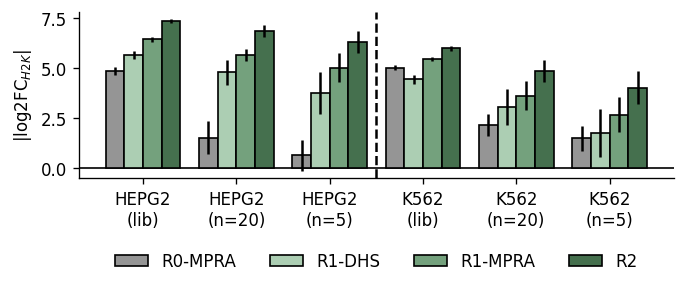

In [18]:
## attemping merged version with the actual measured best enhancer plot

top_enhancer_df['cell_type_plus_n'] = top_enhancer_df['cell_type'] + '_0'
top_enhancer_df['n_samples'] = 0

# concatenate sim_top_enhancer_df with top_enhancer_df
cols = sim_top_enhancer_df.columns
# pd.concat([top_enhancer_df[cols],sim_top_enhancer_df])
sim_top_enhancer_df = pd.concat([top_enhancer_df[cols],sim_top_enhancer_df])
# reset index
sim_top_enhancer_df.reset_index(drop=True,inplace=True)

# sort cur_top_enhancer_df by cell type (HEPG2, then K562); then by round (R0, R1, R2)
sim_top_enhancer_df.sort_values(by=['n_samples','cell_type','round'],inplace=True)

# rename R1D to R1-D
sim_top_enhancer_df['round'] = sim_top_enhancer_df['round'].apply(lambda x: 'R1-D' if x == 'R1D' else x)

# barplots of |log2FoldChange_H2K_d3| with lfsSE_H2K error bars, x-axis = cell_type, hue=round
custom_color_vec = ["#f2f3ae","#edd382","#fc9e4f","#f4442e","#020122"]
palette = {
    'R0': custom_color_vec[0],
    'R1': custom_color_vec[2],
    'R1D' : custom_color_vec[1],
    'R2': custom_color_vec[3],
}

custom_color_vec = ["#FC440F","#5B5F97","#FFC145","#BBE1C3","#6C9A8B"]
custom_green_palette = sns.cubehelix_palette(start=2, rot=0, dark=0, light=.95)
round_palette = {
    'R0': sns.color_palette("Grays", 5)[2],
    'R1-D': custom_green_palette[1],
    'R1': custom_green_palette[2],
    'R2': custom_green_palette[3],
}


# order = ['HEPG2_5','HEPG2_10','HEPG2_20','K562_5','K562_10','K562_20']
order = ['HEPG2_0','HEPG2_20','HEPG2_5','K562_0','K562_20','K562_5',]

# Create a bar plot with custom error values
shrink = .8
plt.figure(figsize=(8*shrink,2.25*shrink))
sns.barplot(
    x='cell_type_plus_n',
    y='log2FoldChange_H2K_d3_abs',
    hue='round',
    order = order,
    hue_order = ['R0','R1-D','R1','R2'],
    data=sim_top_enhancer_df[sim_top_enhancer_df['n_samples']!=10],
    palette=round_palette,
    edgecolor='black'
)

xticks = ['HEPG2\n(lib)','HEPG2\n(n=20)','HEPG2\n(n=5)','K562\n(lib)','K562\n(n=20)','K562\n(n=5)']
plt.xticks(ticks=np.arange(6),labels=xticks)

# barplot with black edges
# sns.barplot(
#     x='cell_type_plus_n',
#     y='log2FoldChange_H2K_d3_abs',
#     hue='round',
#     order = order,
#     data=sim_top_enhancer_df,
#     palette=palette,
#     edgecolor='black'


# Plot custom error bars

# order = [('R0','HEPG2_5'),('R0','HEPG2_10'),('R0','HEPG2_20'),('R0','K562_5'),('R0','K562_10'),('R0','K562_20'),
#          ('R1','HEPG2_5'),('R1','HEPG2_10'),('R1','HEPG2_20'),('R1','K562_5'),('R1','K562_10'),('R1','K562_20'),
#          ('R2','HEPG2_5'),('R2','HEPG2_10'),('R2','HEPG2_20'),('R2','K562_5'),('R2','K562_10'),('R2','K562_20')]

order = [('R0','HEPG2_0'),('R0','HEPG2_20'),('R0','HEPG2_5'),('R0','K562_0'),('R0','K562_20'),('R0','K562_5'),
         ('R1-D','HEPG2_0'),('R1-D','HEPG2_20'),('R1-D','HEPG2_5'),('R1-D','K562_0'),('R1-D','K562_20'),('R1-D','K562_5'),
         ('R1','HEPG2_0'),('R1','HEPG2_20'),('R1','HEPG2_5'),('R1','K562_0'),('R1','K562_20'),('R1','K562_5'),
         ('R2','HEPG2_0'),('R2','HEPG2_20'),('R2','HEPG2_5'),('R2','K562_0'),('R2','K562_20'),('R2','K562_5')]

for i, bar in enumerate(plt.gca().patches):
    if i < 24:
        round,cell_type = order[i]
        # # Get the standard error value from the 'lfsSE_H2K' column
        err = sim_top_enhancer_df.loc[(sim_top_enhancer_df['round']==round) & (sim_top_enhancer_df['cell_type_plus_n']==cell_type),'lfcSE_H2K'].values[0]
        # err = cur_top_enhancer_df.iloc[i]['lfcSE_H2K']

        # Calculate the coordinates for the error bar
        x = bar.get_x() + bar.get_width() / 2
        y = bar.get_height()
        # print(f"{x}: {cell_type} {round}: {y:.2f} +/- {err:.2f}") # to confirm this matches
        
        # Plot the error bar
        plt.errorbar(x, y, yerr=err, color='black', capsize=0)

# Set plot labels and title
plt.xlabel('')
plt.ylabel('|log2FC$_{H2K}$|')
plt.title('')

# # add dot pattern to 2,3,5,6
# for i in [1,2,4,5,
#           13,14,16,17,
#           25,26,28,29]:
#     plt.gca().get_children()[i].set_hatch('//')



# divider between HEPG2 and K562
plt.axvline(x=2.5, color='k', linestyle='--')
# horizontal line at 0
plt.axhline(y=0, color='k', linestyle='-',linewidth=1,zorder=-5)

# move legend below plot
# also rename categories to R0-MPRA, R1-DHS, R1-MPRA, R2
legend = plt.legend(bbox_to_anchor=(0.5, -0.5), loc='center', ncol=4,frameon=False,fontsize=TEXT_FSIZE)

# rename legend labels
for t,text in zip(legend.texts,['R0-MPRA','R1-DHS','R1-MPRA','R2']):
    t.set_text(text)

# plt.legend(bbox_to_anchor=(0.5, -0.5), loc='center', ncol=4,frameon=False,fontsize=TEXT_FSIZE)
# remove legend
# plt.legend().remove()

# despine
sns.despine()

# save plot at high dpi
plt.savefig(f'{fig1_dir}/fig1f_low_n_best_enhancer_sim.png',dpi=600,bbox_inches='tight')


In [86]:
results_df = pd.DataFrame(columns=['cell_type','n_samples','round','percent_best'])


for cur_cell_type in ['HEPG2','K562']:
    for n_samples in n_samples_vec:
        cur_score_vecs = bootstrap_score_vecs[cur_cell_type][n_samples]
        round_scores = np.array([cur_score_vecs[round] for round in ['R0','R1D','R1','R2']]).T # n_bootstraps x n_rounds (1000 x 2, currently)
        round_scores = np.abs(round_scores) # take absolute value of scores so can report both cell types on same axis (assume no negative scores in H, positive scores in K)

        # get the best round for each bootstrap
        best_rounds = np.argmax(round_scores,axis=1)
        n_r2_best = np.sum(best_rounds==3)
        n_r1_best = np.sum(best_rounds==2)
        n_r1d_best = np.sum(best_rounds==1)
        n_r0_best = np.sum(best_rounds==0)
        print(f'{cur_cell_type} R0 best: {n_r0_best/best_rounds.shape[0]}, R1-D best: {n_r1d_best/best_rounds.shape[0]}, R1 best: {n_r1_best/best_rounds.shape[0]}, R2 best: {n_r2_best/best_rounds.shape[0]}')

        results_df = pd.concat([results_df,pd.DataFrame({'cell_type':cur_cell_type,'n_samples':n_samples,'round':'R0','percent_best':[n_r0_best/best_rounds.shape[0],]})])
        results_df = pd.concat([results_df,pd.DataFrame({'cell_type':cur_cell_type,'n_samples':n_samples,'round':'R1-D','percent_best':[n_r1d_best/best_rounds.shape[0],]})])
        results_df = pd.concat([results_df,pd.DataFrame({'cell_type':cur_cell_type,'n_samples':n_samples,'round':'R1','percent_best':[n_r1_best/best_rounds.shape[0],]})])
        results_df = pd.concat([results_df,pd.DataFrame({'cell_type':cur_cell_type,'n_samples':n_samples,'round':'R2','percent_best':[n_r2_best/best_rounds.shape[0],]})])


HEPG2 R0 best: 0.0, R1-D best: 0.0072, R1 best: 0.0673, R2 best: 0.9255
HEPG2 R0 best: 0.0, R1-D best: 0.0009, R1 best: 0.0209, R2 best: 0.9782
HEPG2 R0 best: 0.0, R1-D best: 0.0002, R1 best: 0.0056, R2 best: 0.9942
K562 R0 best: 0.006, R1-D best: 0.063, R1 best: 0.1199, R2 best: 0.8111
K562 R0 best: 0.0027, R1-D best: 0.0421, R1 best: 0.0987, R2 best: 0.8565
K562 R0 best: 0.0008, R1-D best: 0.0204, R1 best: 0.0993, R2 best: 0.8795


C:\Users\Chris\AppData\Local\Temp\ipykernel_33496\1184994134.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df,pd.DataFrame({'cell_type':cur_cell_type,'n_samples':n_samples,'round':'R0','percent_best':[n_r0_best/best_rounds.shape[0],]})])


In [87]:
# add on the full library success rate comparison

load = True

if load:
    results_df = pd.read_csv(f'{bootstrap_sim_dir}/results_df_relative_success.csv')
else:
    
    for cur_cell_type in ['HEPG2','K562']:

        score_func = score_func_dict[cur_cell_type]

        cur_scores_vec = []

        for round,cur_analysis_df in zip(['R0','R1-D','R1','R2'],[d1_analysis_df,dhs_design_df,d2_analysis_df,d3_analysis_df]):

            cur_scores = cur_analysis_df[cur_analysis_df['cell_type']==cur_cell_type][f'{H2K_COL}'].values
            bootstrap_mean_vec = []
            bootstrap_std_vec = []
            n_samples = len(cur_scores)
            bootstrap_mean,bootstrap_std,bootstrap_scores = gen_bootstrap_with_scores(cur_scores,n_samples=n_samples,n_bootstraps=n_bootstraps,score_func=score_func)
            cur_scores_vec.append(bootstrap_scores)
            # bootstrap_score_vecs[cell_type][n_samples][round] = bootstrap_scores


        round_scores = np.array(cur_scores_vec).T # n_bootstraps x n_rounds (1000 x 2, currently)
        round_scores = np.abs(round_scores) # take absolute value of scores so can report both cell types on same axis (assume no negative scores in H, positive scores in K)

        # get the best round for each bootstrap
        best_rounds = np.argmax(round_scores,axis=1)
        n_r2_best = np.sum(best_rounds==3)
        n_r1_best = np.sum(best_rounds==2)
        n_r1d_best = np.sum(best_rounds==1)
        n_r0_best = np.sum(best_rounds==0)
        print(f'{cur_cell_type} R0 best: {n_r0_best/best_rounds.shape[0]}, R1-D best: {n_r1d_best/best_rounds.shape[0]}, R1 best: {n_r1_best/best_rounds.shape[0]}, R2 best: {n_r2_best/best_rounds.shape[0]}')

        # not actually n_samples = 100, n_samples varies by library, it's just the library size
        results_df = pd.concat([results_df,pd.DataFrame({'cell_type':cur_cell_type,'n_samples':100,'round':'R0','percent_best':[n_r0_best/best_rounds.shape[0],]})])
        results_df = pd.concat([results_df,pd.DataFrame({'cell_type':cur_cell_type,'n_samples':100,'round':'R1-D','percent_best':[n_r1d_best/best_rounds.shape[0],]})])
        results_df = pd.concat([results_df,pd.DataFrame({'cell_type':cur_cell_type,'n_samples':100,'round':'R1','percent_best':[n_r1_best/best_rounds.shape[0],]})])
        results_df = pd.concat([results_df,pd.DataFrame({'cell_type':cur_cell_type,'n_samples':100,'round':'R2','percent_best':[n_r2_best/best_rounds.shape[0],]})])

    # save results_df
    results_df.to_csv(f'{bootstrap_sim_dir}/results_df_relative_success.csv',index=False)


HEPG2 R0 best: 0.0, R1-D best: 0.0, R1 best: 0.0, R2 best: 1.0
K562 R0 best: 0.0, R1-D best: 0.0, R1 best: 0.0, R2 best: 1.0


In [103]:
cur_cell_type = 'HEPG2'
cur_n = 5
cur_results_df = results_df[(results_df['cell_type']==cur_cell_type)&(results_df['n_samples']==cur_n)]
# cur_results_df
cur_results_df[cur_results_df['percent_best']>=0.01]

,cell_type,n_samples,round,percent_best
0,HEPG2,5,R1,0.0673
0,HEPG2,5,R2,0.9255


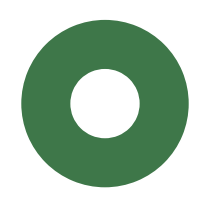

In [143]:
cur_cell_type = 'HEPG2'
cur_n = 100
cur_results_df = results_df[(results_df['cell_type']==cur_cell_type)&(results_df['n_samples']==cur_n)]
# cur_results_df = cur_results_df[cur_results_df['round']!='R0']
percent_thresh = 0.01
cur_results_df = cur_results_df[cur_results_df['percent_best']>=percent_thresh]

labels, sizes = cur_results_df['round'], cur_results_df['percent_best']

# Create the pie chart
plt.figure(figsize=(2,2))

# colors = [round_palette['R1']] + [round_palette['R2']]
colors = [round_palette[round] for round in labels]

# labels=labels, autopct='%1.1f%%'
plt.pie(sizes,startangle=45, colors = colors,pctdistance=1.4,
        wedgeprops=dict(width=0.6, edgecolor='w'), textprops={'fontsize': 20})
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
# plt.title(f'{cell_type.split("_")[0]} n={cur_n}',fontsize=TITLE_FSIZE)
plt.title('')

# Show the chart
# plt.show()
# save plot at high dpi
plt.savefig(f'{fig1_dir}/fig2_low_n_best_enhancer_pie_{cur_cell_type}_n{cur_n}.png',dpi=600,bbox_inches='tight')



### Figure 2G: Target Accuracy ###

In [67]:
model_types = ['d1_finetuned'] # these are the only model types with targets
# design_types = ['fsp','d2_rand_ctrl','d2_top_ctrl','NC']
design_types = ['fsp_tgt','fsp_clipped']
analysis_df = d3_seq_df[(d3_seq_df['model_type'].isin(model_types)) & (d3_seq_df['design_type'].isin(design_types))].copy()
# drop log2(SKNSH_pred) column
analysis_df.drop(columns=['log2(SKNSH)_pred'], inplace=True)
print(analysis_df.shape)
print(analysis_df['target'].unique())

# I want to batch-correct the d2 target values first
_,_,_,_,m_h2k_d23,b_h2k_d23 = np.load('batch_correction_weights/d2_to_d3_linregs_weighted_pf.npy')
analysis_df['target'] = m_h2k_d23*analysis_df['target'] + b_h2k_d23
# round target to 2 decimal places
analysis_df['target'] = analysis_df['target'].apply(lambda x: f'{x:.2f}')

group_cnts = analysis_df.groupby(['model_type','cell_type']).size().reset_index(name='counts')
group_cnts
# ugh I guess I could do stratified, blegh I don't want to figure out how to do this

(380, 16)
[ 2.    3.47  4.95  6.42 -2.   -2.68 -3.35 -4.03  7.07 -4.43]


,model_type,cell_type,counts
0,d1_finetuned,HEPG2,190
1,d1_finetuned,K562,190


In [51]:
analysis_df.groupby('cell_type')['design_type'].value_counts()

cell_type  design_type
HEPG2      fsp_clipped    110
           fsp_tgt         80
K562       fsp_clipped    110
           fsp_tgt         80
Name: count, dtype: int64

In [132]:
analysis_df.groupby('target')[[HEPG2_COL,K562_COL,H2K_COL]].mean().sort_values(by='target',ascending=True)

,log2FoldChange_HepG2,log2FoldChange_K562,log2FoldChange_H2K
target,,,
-1.67,-1.543265,-1.141645,-0.401620
-2.27,-1.077380,0.169551,-1.246931
-2.86,-0.717474,0.695281,-1.412756
-3.46,-0.287739,2.408332,-2.696072
-3.81,-0.338124,2.243827,-2.581951
1.85,-1.781680,-1.980457,0.198777
3.15,-1.254389,-1.854480,0.600091
4.45,1.086918,-1.481638,2.568556
5.75,1.578941,-2.104162,3.683103


In [26]:
xticks = [float(x) for x in analysis_df['target'].unique()]
xticks.sort()

In [29]:
xticks

[-3.81, -3.46, -2.86, -2.27, -1.67, 1.85, 3.15, 4.45, 5.75, 6.32]

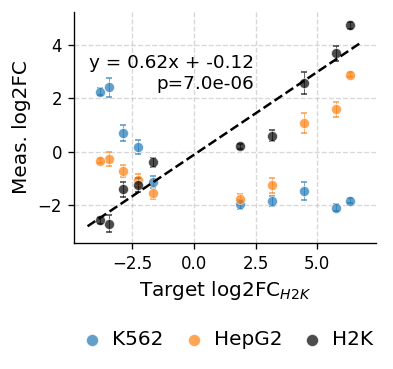

In [69]:
# scatterplot with se bars for mean H2K_COL vs target
# create ax
fig,ax = plt.subplots(figsize=(3.25,2.5))

target_mean_df = analysis_df.groupby(['target'])[H2K_COL].mean().reset_index(name='mean')
target_sem_df = analysis_df.groupby(['target'])[H2K_COL].sem().reset_index(name='sem')

target_hepg2_mean_df = analysis_df.groupby(['target'])[HEPG2_COL].mean().reset_index(name='mean')
target_hepg2_sem_df = analysis_df.groupby(['target'])[HEPG2_COL].sem().reset_index(name='sem')

target_k562_mean_df = analysis_df.groupby(['target'])[K562_COL].mean().reset_index(name='mean')
target_k562_sem_df = analysis_df.groupby(['target'])[K562_COL].sem().reset_index(name='sem')

# convert target column to float
target_mean_df['target'] = target_mean_df['target'].astype(float)
target_sem_df['target'] = target_sem_df['target'].astype(float)

target_hepg2_mean_df['target'] = target_hepg2_mean_df['target'].astype(float)
target_hepg2_sem_df['target'] = target_hepg2_sem_df['target'].astype(float)

target_k562_mean_df['target'] = target_k562_mean_df['target'].astype(float)
target_k562_sem_df['target'] = target_k562_sem_df['target'].astype(float)

alpha = 0.7
sns.scatterplot(data=target_k562_mean_df,x='target',y='mean',ax=ax,color='tab:blue',rasterized=True,alpha=alpha,zorder=15,label='K562')
sns.scatterplot(data=target_hepg2_mean_df,x='target',y='mean',ax=ax,color='tab:orange',rasterized=True,alpha=alpha,zorder=15,label='HepG2')
sns.scatterplot(data=target_mean_df,x='target',y='mean',ax=ax,color='black',rasterized=True,alpha=alpha,zorder=15,label='H2K')

# add error bars
# create ecolor of tab:orange with alpha set to alpha
ecolor_hepg2 = list(sns.color_palette()[1]) + [alpha]
# create ecolor of tab:blue with alpha set to alpha
ecolor_k562 = list(sns.color_palette()[0]) + [alpha]
ax.errorbar(target_k562_mean_df['target'],target_k562_mean_df['mean'],yerr=target_k562_sem_df['sem'],
            fmt='none',elinewidth=0.5,ecolor=ecolor_k562,capsize=2,zorder=10,alpha=alpha,barsabove=False)
ax.errorbar(target_hepg2_mean_df['target'],target_hepg2_mean_df['mean'],yerr=target_hepg2_sem_df['sem'],
            fmt='none',elinewidth=0.5,ecolor=ecolor_hepg2,capsize=2,zorder=10,alpha=alpha,barsabove=False)
ax.errorbar(target_mean_df['target'],target_mean_df['mean'],yerr=target_sem_df['sem'],
            fmt='none',elinewidth=0.5,ecolor='black',capsize=2,zorder=10,alpha=alpha,barsabove=False)
# gridlines

# add regression line
# m,b = np.polyfit(target_mean_df['target'].values,target_mean_df['mean'].values,1)
# add regression line and also calculate slope significance
m,b,r,p,stderr = linregress(target_mean_df['target'].values,target_mean_df['mean'].values)
xmin,xmax = ax.get_xlim()
ymin,ymax = ax.get_ylim()
xmin = min(xmin,ymin)
xmax = max(xmax,ymax)
ax.plot([xmin,xmax],[m*xmin+b,m*xmax+b],linestyle='--',color='black',zorder=21)

# add line of best fit equation and p-value
# ax.annotate(f'y = {m:.2f}x + {b:.2f}\np={p:.1e}\n$r^2$ = {r**2:.2f}',xy=(xmin+1,ymax+1),xytext=(4,-4), textcoords='offset points',va='top')
# add text f'y = {m:.2f}x + {b:.2f}\np={p:.1e}\n$r^2$ = {r**2:.2f}'
ax.annotate(f'y = {m:.2f}x + {b:.2f}\np={p:.1e}',xy=(xmax,ymin),xytext=(-65,90),
            textcoords='offset points',ha='right',va='bottom',zorder=40,fontsize=11)

# # set xticks to xticks
# ax.set_xticks(xticks)
# # rotate xticks
# ax.set_xticklabels(xticks,rotation=90)

# # also plot line of unity
# ax.plot([xmin,xmax],[xmin,xmax],linestyle='--',color='gray',zorder=21)
# despine
sns.despine()
# xlabel
ax.set_xlabel('Target log2FC$_{H2K}$',fontsize=AXIS_FSIZE)
# ylabel
ax.set_ylabel('Meas. log2FC',fontsize=AXIS_FSIZE) # $_{H2K}$
ax.grid(True,ls='--',zorder=0,alpha=0.5)

# legend to the right and outside of the plot
# ax.legend(loc='upper right', bbox_to_anchor=(1.4, 0.8), ncol=1,frameon=False,fontsize=AXIS_FSIZE,
#           handletextpad=0,markerscale=1.2)
# legend above and outside plot with 3 cols
ax.legend(loc='upper right', bbox_to_anchor=(1.05, -.3), ncol=3,frameon=False,fontsize=AXIS_FSIZE,
            handletextpad=0,columnspacing=0.5,markerscale=1.2)

# save figure
plt.savefig(f'{fig1_dir}/fig2_target_meas_corr.png',dpi=600,bbox_inches='tight')